# **Covid-19 Fake News detection using Naive Bayes Classifier**

## 1. Dataset Loading and visualisation

### Required imports

In [1]:
# Used for dataset loading and visualisation
import pandas as pd
import seaborn as seaborn
import matplotlib.pyplot as plt

### Dataset Loading

In [2]:
# Load training dataset into a pandas dataframe
df_train = pd.read_csv('datasets/TrainData.csv')

# Load validation dataset into a pandas dataframe
df_val = pd.read_csv('datasets/ValData.csv')

# Load testing dataset into a pandas dataframe
df_test = pd.read_csv('datasets/TestData.csv')

In [3]:
# 5 sample rows from the training dataset
df_train.head(5)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [4]:
# 5 first rows from the training dataset
df_val.head(5)

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [5]:
# 5 sample rows from the training dataset
df_test.head(5)

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


### Statistics

In [6]:
# Training Data checking
shape = df_train.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_train.isnull().values.any())
print('The distribution of data into classes is:')
df_train['label'].value_counts()

There are 6420 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    3360
fake    3060
Name: label, dtype: int64

In [7]:
# Validation Data checking
shape = df_val.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_val.isnull().values.any())
print('The distribution of data into classes is:')
df_val['label'].value_counts()

There are 2140 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    1120
fake    1020
Name: label, dtype: int64

In [8]:
# Testing Data checking
shape = df_test.shape
print('There are {0} tweets and {1} columns for each tweet.'.format(shape[0], shape[1]))
print('Is there any null value? ', df_test.isnull().values.any())
print('The distribution of data into classes is:')
df_test['label'].value_counts()

There are 2140 tweets and 3 columns for each tweet.
Is there any null value?  False
The distribution of data into classes is:


real    1120
fake    1020
Name: label, dtype: int64

### Droping the columns that are not necessary

In [9]:
columns_to_drop = ['id']
df_train = df_train.drop(columns_to_drop, axis = 1)
df_val = df_val.drop(columns_to_drop, axis = 1)
df_test = df_test.drop(columns_to_drop, axis = 1)
df_train.head(2)

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real


### Merging test and val data to use in k-fold cross validation

In [10]:
df_train = pd.concat([df_train, df_val], ignore_index=True)

### Plotting the class-wise distribution of datasets

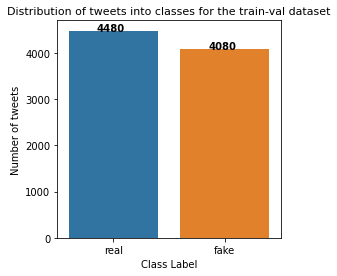

In [11]:
plt.figure(figsize=(4, 4))

ax = seaborn.countplot(
    x = df_train['label'],  
    data = df_train, 
    order = df_train['label'].value_counts().index 
)

ax.set_title('Distribution of tweets into classes for the train-val dataset', fontsize = 11)
ax.set_xlabel ('Class Label')
ax.set_ylabel ('Number of tweets')

for p, label in zip(ax.patches, df_train['label'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5), weight = 'bold')

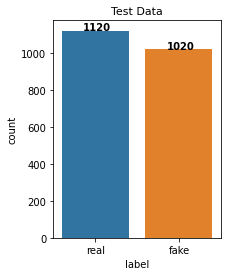

In [12]:
plt.figure(figsize=(3,4))

ax = seaborn.countplot(
    x = df_test['label'], 
    data = df_test, 
    order = df_test['label'].value_counts().index 
    )

ax.set_title('Test Data', fontsize=11)
ax.set_xlabel ('label')
ax.set_ylabel ('count')

for p, label in zip(ax.patches, df_test['label'].value_counts()):
    ax.annotate(label, (p.get_x() + 0.25, p.get_height() + 0.5), weight = 'bold')

## 2. Pre-processing

### Required imports

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
import string
import re
from collections import Counter
from numpy import array

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Pre-processing Function

In [15]:
def clean_tweet(tweet):
    # lowercasing the text
    tweet = tweet.lower()
    
    # URL normalization
    url_pattern = '(\w+:\/\/\S+)'
    tweet = re.sub(url_pattern, 'url', tweet)
    
    # Mentions normalization
    mention_pattern = '(\^@[._A-Za-z0-9]+)'
    tweet = re.sub(mention_pattern, '@user', tweet)
    
    # Contractions expansion
    tweet = contractions.fix(tweet)
    
    # split into tokens by white space
    words = tweet.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    
    # remove punctuation from each word
    words = [re_punc.sub('', w) for w in words]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha() or word == 'covid19']
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    # filter out short tokens
    words = [word for word in words if len(word) > 2]
        
    return " ".join(words)

In [16]:
print(clean_tweet('WHO announces Algeria outside of danger regarding COVID-19'))

announces algeria outside danger regarding covid19


In [17]:
# Testing the function
sampleTweet = df_train['tweet'][4]
tokens = clean_tweet(sampleTweet)
print('Original tweet: ', sampleTweet,'\n')
print('Pre-processed :', tokens, '\n')

Original tweet:  Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per million than California or Texas: AL AR ID KS KY LA MS NV and SC. https://t.co/1pYW6cWRaS 

Pre-processed : populous states generate large case counts look new cases per million today smaller states showing cases per million california texas url 



### Applying pre-processing to training and test data

In [18]:
# Preprocess trainingData
df_train['tweet'] = df_train['tweet'].map(lambda x: clean_tweet(x))

# Preprocess validationData
df_test['tweet'] = df_test['tweet'].map(lambda x: clean_tweet(x))

## 3. Feature Extraction

##### 1. BOW Model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(df_train['tweet'])

print("There are {} tweets, each of them represented as a {} dim feature vector"\
      .format(X_train_counts.shape[0], X_train_counts.shape[1]))

There are 8560 tweets, each of them represented as a 14140 dim feature vector


In [22]:
print(vectorizer.get_feature_names()) #Printing fatures
print(X_train_counts.toarray()) #Feature values

['aadab', 'aadajoli', 'aaiofficial', 'aaj', 'aajtak', 'aamaadmiparty', 'aamctoday', 'aamir', 'aampe', 'aampes', 'aap', 'aaradhya', 'ababa', 'abacha', 'abakaliki', 'abandon', 'abandoned', 'abating', 'abba', 'abbasi', 'abbott', 'abbottnews', 'abbreviation', 'abbys', 'abc', 'abcfactcheck', 'abcmediawatch', 'abcworldnews', 'abdicated', 'abdul', 'abdulaziz', 'abhigyan', 'abhishek', 'abia', 'abide', 'ability', 'able', 'abledoc', 'ableg', 'abnormally', 'aboard', 'aborted', 'abortion', 'abound', 'aboveinflation', 'aboveremained', 'abp', 'abpnews', 'abraham', 'abruptly', 'abscbn', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absorb', 'absorbed', 'abt', 'abubakar', 'abuja', 'abundantly', 'abused', 'abysmal', 'aca', 'academic', 'academy', 'acalabrutinib', 'acc', 'accelerate', 'accelerates', 'accelerating', 'acceleration', 'accelerator', 'acceleratordrtedros', 'accept', 'acceptable', 'accepted', 'access', 'accessdrtedros', 'accessibility', 'accessible', 'accident', 'accidental', 'ac

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [25]:
counts = X_train_counts.toarray()[10]
features = vectorizer.get_feature_names()

print('Preprocessed tweet:', df_train['tweet'][10], '\n')
print('Occurrencies: ')
for i in range(len(features)):
    count = counts[i]
    if(count > 0):
        print('{}: {}'.format(features[i], count))

Preprocessed tweet: take simple daily precautions help prevent spread respiratory illnesses like covid19 learn protect coronavirus covid19 url url 

Occurrencies: 
coronavirus: 1
covid19: 2
daily: 1
help: 1
illnesses: 1
learn: 1
like: 1
precautions: 1
prevent: 1
protect: 1
respiratory: 1
simple: 1
spread: 1
take: 1
url: 2


##### 2. TF-IDF Representation

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf = False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape
print('There are {} tweets and {} is the size of the vocabulary for all the tweets'\
      .format(X_train_tf.shape[0], X_train_tf.shape[1]))

There are 8560 tweets and 14140 is the size of the vocabulary for all the tweets


## 4. Naive Bayes

#### Model Training

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score

pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('clf', MultinomialNB())
    ])

scoring = {'prec_macro': 'precision_macro', 'rec_macro': make_scorer(recall_score, average='macro'), 'f1_macro': 'f1_macro', 'accuracy': 'accuracy'}
scores = cross_validate(pipeline, df_train['tweet'], df_train['label'], cv = 5, scoring = scoring, return_train_score = True)

In [30]:
print('Mean Accuracy:', scores['test_accuracy'].mean())
scores['test_accuracy']

Mean Accuracy: 0.901285046728972


array([0.90070093, 0.89953271, 0.90595794, 0.89602804, 0.90420561])

In [31]:
print('Mean F1:', scores['test_f1_macro'].mean())
scores['test_f1_macro']

Mean F1: 0.90038340532628


array([0.8998479 , 0.89855584, 0.90498774, 0.89504124, 0.90348431])

In [32]:
print('Mean Precision:', scores['test_prec_macro'].mean())
scores['test_prec_macro']

Mean Precision: 0.9063178045186007


array([0.90517966, 0.90509694, 0.91228059, 0.90128337, 0.90774846])

In [33]:
print('Mean Recall:', scores['test_rec_macro'].mean())
scores['test_rec_macro']

Mean Recall: 0.8988095238095237


array([0.89834996, 0.89690564, 0.90320816, 0.893448  , 0.90213585])

In [34]:
fit = pipeline.fit(df_train['tweet'], df_train['label'])

#### Prediction on test data

In [35]:
predictions = pipeline.predict(df_test['tweet'])

In [36]:
from sklearn.metrics import classification_report,confusion_matrix

print('-----------------Naive Bayes Classifier------------------\n')
print(classification_report(df_test['label'], predictions))

-----------------Naive Bayes Classifier------------------

              precision    recall  f1-score   support

        fake       0.95      0.85      0.90      1020
        real       0.87      0.96      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.90      0.91      2140
weighted avg       0.91      0.91      0.91      2140



In [ ]:
# Plot confusion matrix
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

data = {'true_labels': df_test['label'], 'predicted_labels': predictions}

df = pd.DataFrame(data, columns = ['true_labels', 'predicted_labels'])

confusion_matrix = pd.crosstab(
    df['true_labels'], 
    df['predicted_labels'], 
    rownames = ['True Label'], 
    colnames = ['Predicted Label']
    )

fig, ax = plt.subplots(figsize=(7,5))
sbn.heatmap(confusion_matrix, annot = True, linewidths = 1, fmt = 'd', cmap="Blues")
plt.title("Confusion matrix of Naive Bayes on Test Data")
plt.show()